Klasyfikacja przy użyciu mel spectrogramów

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import copy
import random
import librosa
from collections import Counter
import seaborn as sns
from scipy.stats import randint

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")
print(path)
static_annotations_file = static_csv = os.path.join(path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')
audio_path = os.path.join(path, 'DEAM_audio', 'MEMD_audio',)

C:\Users\Gabi\.cache\kagglehub\datasets\imsparsh\deam-mediaeval-dataset-emotional-analysis-in-music\versions\1


In [3]:
df = pd.read_csv(static_annotations_file)
df

,song_id,valence_mean,valence_std,arousal_mean,arousal_std
0,2,3.1,0.94,3.0,0.63
1,3,3.5,1.75,3.3,1.62
2,4,5.7,1.42,5.5,1.63
3,5,4.4,2.01,5.3,1.85
4,7,5.8,1.47,6.4,1.69
...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,2.21
1740,1997,5.3,1.42,3.9,1.14
1741,1998,6.4,1.50,6.2,1.60
1742,1999,4.6,2.11,5.4,1.80


In [4]:
conditions = [
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] >= 5),
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] >= 5)
]
choices = ['happy', 'relaxed', 'sad', 'anger']
df_4 = df.copy(deep=True)
df_4['emotion'] = np.select(conditions, choices, default=None)
first = df_4.pop('emotion')
df_4.insert(4, 'emotion', first)
df_4

,song_id,valence_mean,valence_std,arousal_mean,emotion,arousal_std
0,2,3.1,0.94,3.0,sad,0.63
1,3,3.5,1.75,3.3,sad,1.62
2,4,5.7,1.42,5.5,happy,1.63
3,5,4.4,2.01,5.3,anger,1.85
4,7,5.8,1.47,6.4,happy,1.69
...,...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,anger,2.21
1740,1997,5.3,1.42,3.9,relaxed,1.14
1741,1998,6.4,1.50,6.2,happy,1.60
1742,1999,4.6,2.11,5.4,anger,1.80


In [6]:
conditions = [
    (4.5 <= df[' valence_mean']) & (df[' valence_mean'] <= 5.5) & (4.5 <= df[' arousal_mean']) & (df[' arousal_mean'] <= 5.5),
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] >= 5),
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] >= 5)
]
choices = ['neutral', 'happy', 'relaxed', 'sad', 'anger']
df_5 = df.copy(deep=True)
df_5['emotion'] = np.select(conditions, choices, default=None)
first = df_5.pop('emotion')
df_5.insert(4, 'emotion', first)
df_5

,song_id,valence_mean,valence_std,arousal_mean,emotion,arousal_std
0,2,3.1,0.94,3.0,sad,0.63
1,3,3.5,1.75,3.3,sad,1.62
2,4,5.7,1.42,5.5,happy,1.63
3,5,4.4,2.01,5.3,anger,1.85
4,7,5.8,1.47,6.4,happy,1.69
...,...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,anger,2.21
1740,1997,5.3,1.42,3.9,relaxed,1.14
1741,1998,6.4,1.50,6.2,happy,1.60
1742,1999,4.6,2.11,5.4,neutral,1.80


In [5]:
with open('../resources/X_spectrogram.pickle', 'rb') as handle:
    X = pickle.load(handle)
with open('../resources/y_spectrogram.pickle', 'rb') as handle:
    y = pickle.load(handle)

Wyrównanie ilości danych w poszczególnych klasach poprze undersampling

In [30]:
X_undersampled = copy.deepcopy(X)
y_undersampled = copy.deepcopy(y)

song_ids = list(X_undersampled.keys())
for song_id in song_ids:
    segment_number = len(X_undersampled[song_id])
    emotion = df_4[df_4['song_id'] == song_id]['emotion'].iloc[0]
    if emotion == 'happy' or emotion == 'sad':
        num_to_remove = int(segment_number * 0.7)
    else:
        continue

    indices_to_remove = sorted(random.sample(range(len(X_undersampled[song_id])), num_to_remove), reverse=True)
    for idx in indices_to_remove:
        del X_undersampled[song_id][idx]
        if song_id in y_undersampled:
            del y_undersampled[song_id][idx]

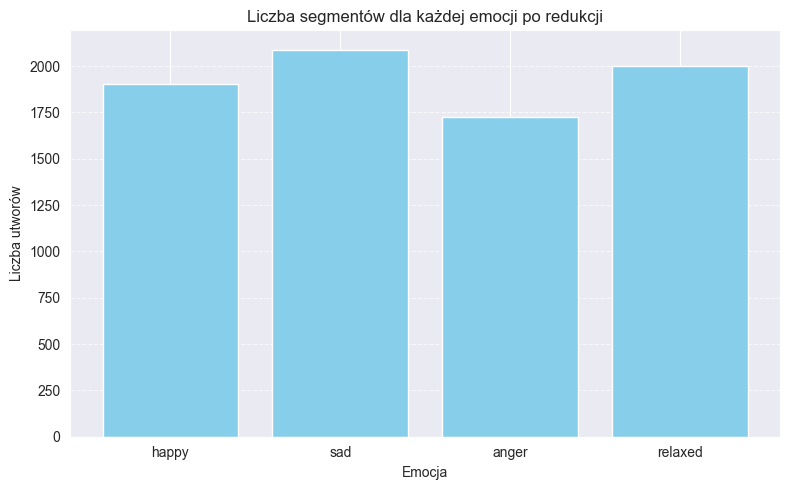

In [8]:
song_ids = list(X_undersampled.keys())
emotion_amount = {
    'happy': 0,
    'sad': 0,
    'anger': 0,
    'relaxed': 0
}
for song_id in song_ids:
    segment_number = len(X_undersampled[song_id])
    emotion = df_4[df_4['song_id'] == song_id]['emotion'].iloc[0]
    if emotion == 'happy':
        emotion_amount['happy'] += segment_number
    elif emotion == 'sad':
        emotion_amount['sad'] += segment_number
    elif emotion == 'anger':
        emotion_amount['anger'] += segment_number
    elif emotion == 'relaxed':
        emotion_amount['relaxed'] += segment_number

labels = list(emotion_amount.keys())
values = list(emotion_amount.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.title('Liczba segmentów dla każdej emocji po redukcji')
plt.xlabel('Emocja')
plt.ylabel('Liczba utworów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

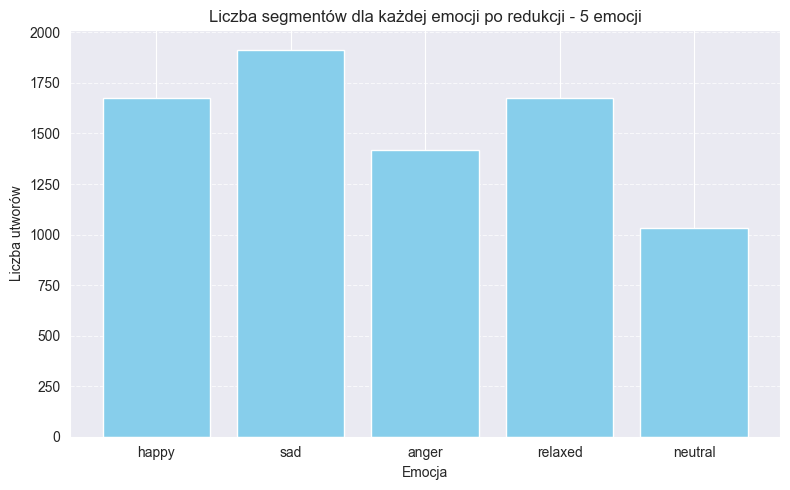

In [9]:
song_ids = list(X_undersampled.keys())
emotion_amount = {
    'happy': 0,
    'sad': 0,
    'anger': 0,
    'relaxed': 0,
    'neutral': 0
}
for song_id in song_ids:
    segment_number = len(X_undersampled[song_id])
    emotion = df_5[df_5['song_id'] == song_id]['emotion'].iloc[0]
    if emotion == 'happy':
        emotion_amount['happy'] += segment_number
    elif emotion == 'sad':
        emotion_amount['sad'] += segment_number
    elif emotion == 'anger':
        emotion_amount['anger'] += segment_number
    elif emotion == 'relaxed':
        emotion_amount['relaxed'] += segment_number
    elif emotion == 'neutral':
        emotion_amount['neutral'] += segment_number

labels = list(emotion_amount.keys())
values = list(emotion_amount.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.title('Liczba segmentów dla każdej emocji po redukcji - 5 emocji')
plt.xlabel('Emocja')
plt.ylabel('Liczba utworów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Zastosowanie najprostszego RandomForestClassifier - wyniki accuracy są podobne jak w poprzednich modelach, jednak po raz pierwszy klasyfikacja jest bardziej zrównoważona - wyniki precision dla każdej emocji są podobne, macierz konfuzji również na to wskazuje.

In [31]:
X_under_flat = []
y_under_flat = []

for song_id in X_undersampled:
    segments = X_undersampled[song_id]
    labels = y_undersampled[song_id]
    for feat, label in zip(segments, labels):
        X_under_flat.append(feat)
        y_under_flat.append(label)

X_under_flat_cnn = np.array(X_under_flat)
X_under_flat = np.array([feat.flatten() for feat in X_under_flat])
y_under_flat = np.array(y_under_flat)
print(X_under_flat.shape)
print(X_under_flat_cnn.shape)
print(y_under_flat.shape)

(7713, 55168)
(7713, 128, 431)
(7713, 2)


In [5]:
def classify_emotion(valence, arousal):
    if valence >= 5 and arousal >= 5:
        return 'happy'
    if valence >= 5 and arousal < 5:
        return 'relaxed'
    if valence <= 5 and arousal <= 5:
        return 'sad'
    if valence <= 5 and arousal >= 5:
        return 'anger'

In [6]:
def classify_emotion_5(valence, arousal):
    if 4.5 <= valence <= 5.5 and 4.5 <= arousal <= 5.5:
        return 'neutral'
    if valence >= 5 and arousal >= 5:
        return 'happy'
    if valence >= 5 and arousal < 5:
        return 'relaxed'
    if valence <= 5 and arousal <= 5:
        return 'sad'
    if valence <= 5 and arousal >= 5:
        return 'anger'

In [34]:
y_under_emotions = []
y_under_emotions_5 = []

for values in y_under_flat:
    y_under_emotions.append(classify_emotion(values[0], values[1]))
    y_under_emotions_5.append(classify_emotion_5(values[0], values[1]))

le = LabelEncoder()
y_under_emotions_en = le.fit_transform(y_under_emotions)
le_5 = LabelEncoder()
y_under_emotions_5_en = le_5.fit_transform(y_under_emotions_5)

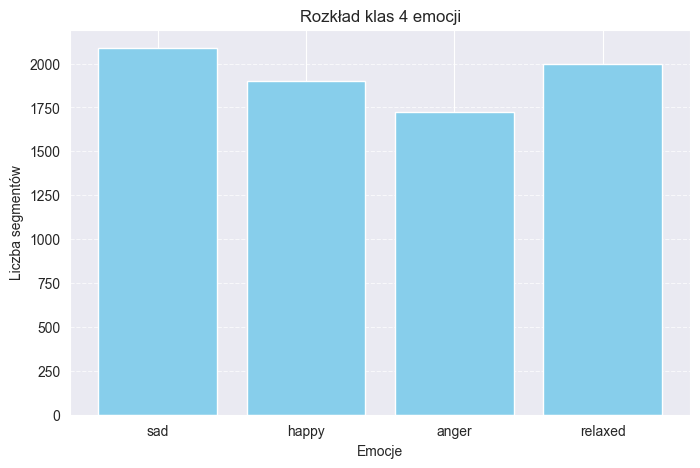

In [42]:
label_counts = Counter(y_under_emotions)
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue')
plt.title('Rozkład klas 4 emocji')
plt.xlabel('Emocje')
plt.ylabel('Liczba segmentów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

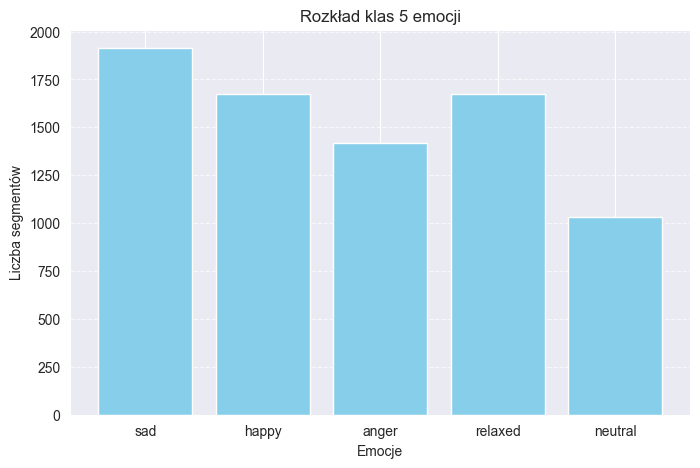

In [43]:
label_counts = Counter(y_under_emotions_5)
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue')
plt.title('Rozkład klas 5 emocji')
plt.xlabel('Emocje')
plt.ylabel('Liczba segmentów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under_flat,
    y_under_emotions_en,
    test_size=0.2,
    random_state=42,
    stratify=y_under_emotions_en)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_under, y_train_under)

y_pred = clf.predict(X_test_under)
print("Accuracy: ", accuracy_score(y_test_under, y_pred))
print(classification_report(y_test_under, y_pred, target_names=le.classes_))

Accuracy:  0.4607906675307842
              precision    recall  f1-score   support

       anger       0.41      0.18      0.25       345
       happy       0.45      0.57      0.50       380
     relaxed       0.40      0.39      0.40       400
         sad       0.53      0.66      0.59       418

    accuracy                           0.46      1543
   macro avg       0.45      0.45      0.43      1543
weighted avg       0.45      0.46      0.44      1543



[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')]

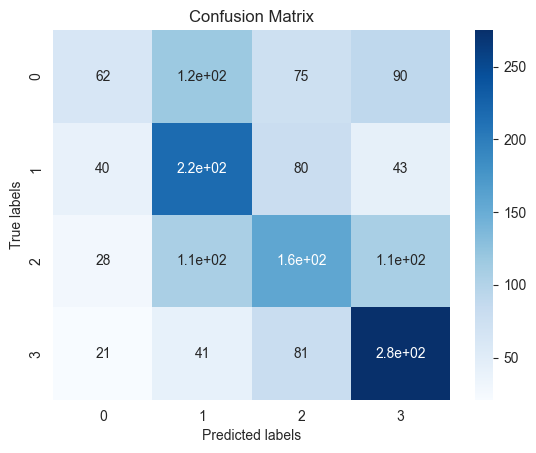

In [48]:
conusion_matrix = confusion_matrix(y_test_under, y_pred)

ax = plt.subplot()
sns.heatmap(conusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(np.unique(y_test_under))
ax.yaxis.set_ticklabels(np.unique(y_test_under))

Dla 5 emocji wyniki są wziąż gorsze - modele nie radzą sobie z rozponaniem emocji neutralnej.

Accuracy:  0.42579390797148414
              precision    recall  f1-score   support

       anger       0.29      0.12      0.17       284
       happy       0.42      0.65      0.51       335
     neutral       0.39      0.09      0.14       206
     relaxed       0.36      0.39      0.37       335
         sad       0.52      0.67      0.59       383

    accuracy                           0.43      1543
   macro avg       0.40      0.38      0.36      1543
weighted avg       0.40      0.43      0.39      1543



[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4')]

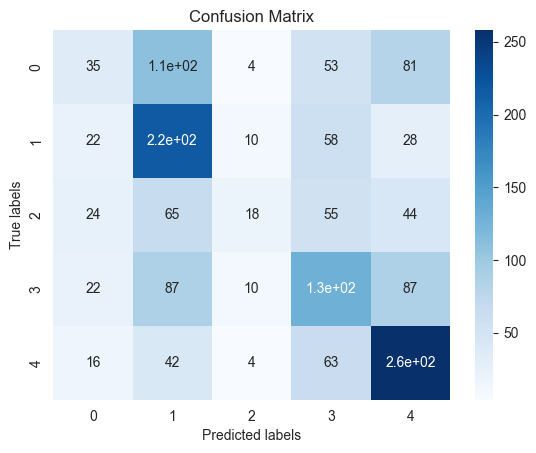

In [49]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under_flat,
    y_under_emotions_5_en,
    test_size=0.2,
    random_state=42,
    stratify=y_under_emotions_5_en)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_under, y_train_under)

y_pred = clf.predict(X_test_under)
print("Accuracy: ", accuracy_score(y_test_under, y_pred))
print(classification_report(y_test_under, y_pred, target_names=le_5.classes_))

[Text(0, 0.5, 'anger'),
 Text(0, 1.5, 'happy'),
 Text(0, 2.5, 'neutral'),
 Text(0, 3.5, 'relaxed'),
 Text(0, 4.5, 'sad')]

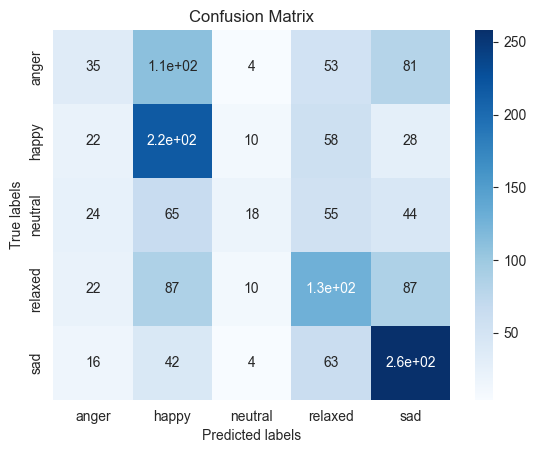

In [53]:
conusion_matrix = confusion_matrix(y_test_under, y_pred)
ax = plt.subplot()
sns.heatmap(conusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(np.unique(le_5.classes_))
ax.yaxis.set_ticklabels(np.unique(le_5.classes_))

RandomForestClassifier z użyciem automatycznego balansowania klas - accuracy odrobinę wyższe

Accuracy:  0.4782890473104342
              precision    recall  f1-score   support

       anger       0.52      0.23      0.32       345
       happy       0.46      0.57      0.51       380
     relaxed       0.40      0.42      0.41       400
         sad       0.55      0.66      0.60       418

    accuracy                           0.48      1543
   macro avg       0.48      0.47      0.46      1543
weighted avg       0.48      0.48      0.46      1543



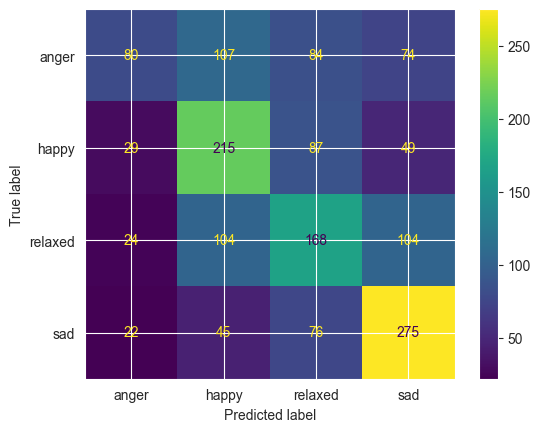

In [35]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under_flat,
    y_under_emotions_en,
    test_size=0.2,
    random_state=42,
    stratify=y_under_emotions_en)

classes = np.unique(y_train_under)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=classes,
                                     y=y_train_under)
class_weight_dict = dict(zip(classes, class_weights))

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
clf.fit(X_train_under, y_train_under)

y_pred = clf.predict(X_test_under)
print("Accuracy: ", accuracy_score(y_test_under, y_pred))
print(classification_report(y_test_under, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_under, y_pred, display_labels=le.classes_)

Sieć CNN do klasyfikacji

In [83]:
X_under_cnn = np.expand_dims(X_under_flat_cnn, axis=-1)
y_under_cnn = to_categorical(y_under_emotions_en)

X_train, X_test, y_train, y_test = train_test_split(X_under_cnn, y_under_cnn, test_size=0.2, random_state=42, stratify=y_under_emotions_en)

In [64]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model_under_4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_under_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_under_4.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 429, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 63, 214, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 212, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 106, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 203520)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    26,050,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,070,404 (99.45 MB)

 Trainable params: 26,070,212 (99.45 MB)

 Non-trainable params: 192 (768.00 B)

In [68]:
history_under_4 = model_under_4.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10),
               tf.keras.callbacks.ModelCheckpoint("spec_class_cnn_model.keras",
                save_best_only=True)]
)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 76s 488ms/step - accuracy: 0.2521 - loss: 1.3822 - val_accuracy: 0.2439 - val_loss: 1.6907
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 72s 465ms/step - accuracy: 0.2665 - loss: 1.3907 - val_accuracy: 0.2723 - val_loss: 2.0087
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 73s 470ms/step - accuracy: 0.2782 - loss: 1.3762 - val_accuracy: 0.2804 - val_loss: 3.0681
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 73s 468ms/step - accuracy: 0.2721 - loss: 1.3782 - val_accuracy: 0.2739 - val_loss: 1.9962
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 72s 465ms/step - accuracy: 0.2719 - loss: 1.3776 - val_accuracy: 0.2739 - val_loss: 2.1464
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 75s 484ms/step - accuracy: 0.2891 - loss: 1.3567 - val_accuracy: 0.2472 - val_loss: 2.1351
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 75s 481ms/step - accuracy: 0.3169 - loss: 1.3297 - val_accuracy: 0.2658 - val_loss: 2.3282
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 74s 479ms/step - accuracy: 0.3414 - loss: 1

Wyniki są dużo niższe niż dla RandomForestClassifier, znowu przewaga predykcji dla jednej klasy happy

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step
Accuracy:  0.28191834089436163
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       345
       happy       0.26      0.96      0.41       380
     relaxed       0.17      0.02      0.04       400
         sad       0.74      0.14      0.24       418

    accuracy                           0.28      1543
   macro avg       0.29      0.28      0.17      1543
weighted avg       0.31      0.28      0.18      1543



C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

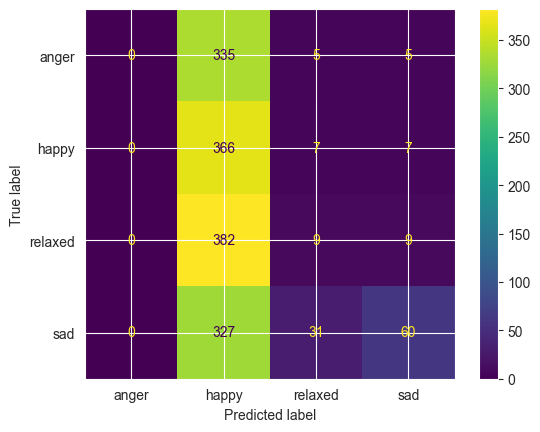

In [75]:
y_pred = model_under_4.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(y_true_labels, y_pred_labels, display_labels=le.classes_)

Zmniejszenie liczby neuronów w sieci

In [76]:
model_under_4 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_under_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_under_4.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 429, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 214, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 63, 214, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 212, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 106, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 106, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 101760)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     6,512,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,956 (24.86 MB)

 Trainable params: 6,517,860 (24.86 MB)

 Non-trainable params: 96 (384.00 B)

In [78]:
history_under_4 = model_under_4.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint("spec_class_cnn_model.keras", save_best_only=True)
    ],
    # class_weight=class_weight_dict  # opcjonalnie, jeśli używasz class weights
)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.2733 - loss: 4.5758 - val_accuracy: 0.2682 - val_loss: 1.4285
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.2742 - loss: 1.5116 - val_accuracy: 0.2707 - val_loss: 1.5373
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - accuracy: 0.2822 - loss: 1.3927 - val_accuracy: 0.2771 - val_loss: 1.5725
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.2793 - loss: 1.3829 - val_accuracy: 0.2763 - val_loss: 1.9410
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.2649 - loss: 1.5383 - val_accuracy: 0.2634 - val_loss: 1.9134
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.2831 - loss: 1.3888 - val_accuracy: 0.2731 - val_loss: 1.8707
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.2686 - loss: 1.3848 - val_accuracy: 0.2666 - val_loss: 2.1108
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - accuracy: 0.2712 - loss: 1

Najwidoczniej tego rodzaju model nie radzi sobie z tymi danymi, tym razem przewaga klasy sad.

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Accuracy:  0.26247569669475046
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       345
       happy       0.16      0.02      0.04       380
     relaxed       0.67      0.01      0.01       400
         sad       0.27      0.94      0.41       418

    accuracy                           0.26      1543
   macro avg       0.27      0.24      0.12      1543
weighted avg       0.28      0.26      0.13      1543



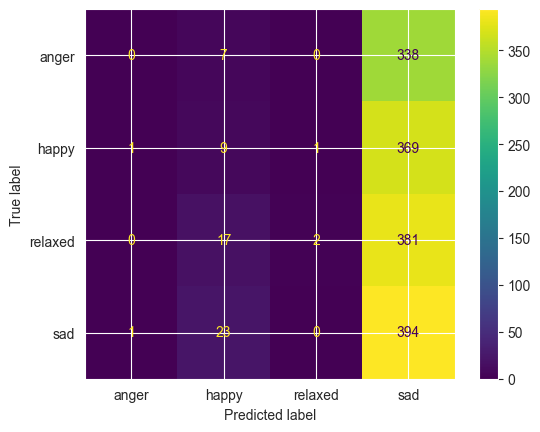

In [79]:
y_pred = model_under_4.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(y_true_labels, y_pred_labels, display_labels=le.classes_)

Nie usuwanie danych, tylko wagi dla klas przy oryginalnym rozkładzie klas.

In [42]:
X_flat = []
y_flat = []

for song_id in X:
    segments = X[song_id]
    labels = y[song_id]
    for feat, label in zip(segments, labels):
        X_flat.append(feat)
        y_flat.append(label)

X_flat_cnn = np.array(X_flat)
X_flat = np.array([feat.flatten() for feat in X_flat])
y_flat = np.array(y_flat)
print(X_flat.shape)
print(X_flat_cnn.shape)
print(y_flat.shape)

(15687, 55168)
(15687, 128, 431)
(15687, 2)


In [43]:
y_emotions = []
y_emotions_5 = []

for values in y_flat:
    y_emotions.append(classify_emotion(values[0], values[1]))
    y_emotions_5.append(classify_emotion_5(values[0], values[1]))

le = LabelEncoder()
y_emotions_en = le.fit_transform(y_emotions)
le_5 = LabelEncoder()
y_emotions_5_en = le_5.fit_transform(y_emotions_5)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_flat,
    y_emotions_en,
    test_size=0.2,
    random_state=42,
    stratify=y_emotions_en)

In [37]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=classes,
                                     y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

In [14]:
class_weight_dict

{0: 2.2733695652173913,
 1: 0.6876918018412976,
 2: 1.963235294117647,
 3: 0.6263226192852864}

In [11]:
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=class_weight_dict
)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 2.2733695652173913,
                                     1: 0.6876918018412976,
                                     2: 1.963235294117647,
                                     3: 0.6263226192852864},
                       random_state=42)

Tym razem 2 klasy, w których jest najwięcej przykładów przeważają (happy i sad)

Accuracy: 0.6175908221797323
              precision    recall  f1-score   support

       anger       1.00      0.00      0.01       345
       happy       0.58      0.81      0.68      1141
     relaxed       0.80      0.02      0.04       400
         sad       0.65      0.80      0.72      1252

    accuracy                           0.62      3138
   macro avg       0.76      0.41      0.36      3138
weighted avg       0.68      0.62      0.54      3138



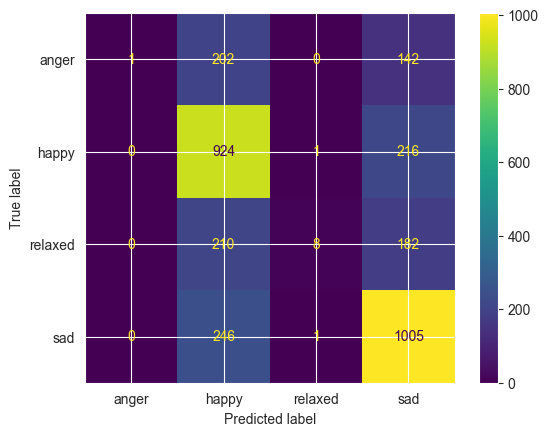

In [20]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_)

To samo dla sieci

In [44]:
X_cnn = np.expand_dims(X_flat_cnn, axis=-1)
y_cnn = to_categorical(y_emotions_en)

X_train, X_test, y_train, y_test = train_test_split(
    X_cnn,
    y_cnn,
    test_size=0.2,
    random_state=42,
    stratify=y_cnn)

In [45]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)

class_weight_dict = dict(enumerate(class_weights))

In [46]:
class_weight_dict

{0: 2.2733695652173913,
 1: 0.6876918018412976,
 2: 1.963235294117647,
 3: 0.6263226192852864}

In [47]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model_4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_4.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 429, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 63, 214, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 212, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 106, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 203520)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    26,050,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,070,404 (99.45 MB)

 Trainable params: 26,070,212 (99.45 MB)

 Non-trainable params: 192 (768.00 B)

In [48]:
history_4 = model_4.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint("spec_class_cnn_model.keras", save_best_only=True)
    ],
    class_weight=class_weight_dict
)

Epoch 1/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 169s 514ms/step - accuracy: 0.1795 - loss: 9.0999 - val_accuracy: 0.0996 - val_loss: 1.5290
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 179s 569ms/step - accuracy: 0.2970 - loss: 1.3998 - val_accuracy: 0.1020 - val_loss: 2.0430
Epoch 3/50
 90/314 ━━━━━━━━━━━━━━━━━━━━ 2:20 628ms/step - accuracy: 0.1166 - loss: 1.3762

KeyboardInterrupt: 

Przerwaliśmy uczenie modelu, ponieważ zajmowało to bardzo dużo czasu, a accuracy widoczne przy walidacji epok było bardzo niskie i nie poprawiało się.

In [ ]:
y_pred = model_4.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(y_true_labels, y_pred_labels, display_labels=le.classes_)

Oversampling - nowe podejście do przetwarzania wstępnego danych. Zamiast usuwać dane, których jest za dużo i ograniczać ilość przykładów zbiorze, tworzymy nowe przykłady tych emocji, których jest najmniej. Odbywa się to poprzez zmianę częstotliwości utwórów oraz dodanie szumu do utworów dla emocji anger i relaxed.

In [6]:
def augment_audio(segment, sr):
    augmented = []

    # Time Stretch
    # rate = random.uniform(0.8, 1.2)
    # stretched = librosa.effects.time_stretch(y=segment, rate=rate)
    # if len(stretched) >= len(segment):
    #     stretched = stretched[:len(segment)]
    # else:
    #     stretched = np.pad(stretched, (0, len(segment) - len(stretched)))
    # augmented.append(stretched)

    # Pitch Shift
    pitch = librosa.effects.pitch_shift(segment, sr=sr, n_steps=random.choice([-2, 2]))
    augmented.append(pitch)

    # Add noise
    noise = segment + 0.005 * np.random.randn(len(segment))
    augmented.append(noise)

    # Time Shift
    # shift = int(0.1 * sr)
    # shifted = np.roll(segment, shift)
    # augmented.append(shifted)

    return augmented

In [7]:
X_over = []
y_over = []

for song_id in df['song_id']:
    emotion = df_4[df_4['song_id'] == song_id]['emotion'].iloc[0]

    y_audio, sr = librosa.load(f"{audio_path}/{song_id}.mp3", sr=44100, mono=True)

    segment_length = 5
    segment_samples = segment_length * sr

    for i in range(0, len(y_audio) - segment_samples, segment_samples):
        segment = y_audio[i:i + segment_samples]
        label = df[df['song_id'] == song_id][[' valence_mean', ' arousal_mean']].values[0]
        emotion_label = classify_emotion(label[0], label[1])

        # Oryginalny segment
        mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        X_over.append(mel_spec_db)
        y_over.append(emotion_label)

        # Augmentacja tylko dla anger / relaxed
        if emotion in ['anger', 'relaxed']:
            for aug in augment_audio(segment, sr=sr):
                mel_spec = librosa.feature.melspectrogram(y=aug, sr=sr, n_mels=128)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                X_over.append(mel_spec_db)
                y_over.append(emotion_label)

In [8]:
X_over_1 = np.array([x if x.shape == (128, 431) else np.pad(x, ((0, 0), (0, 431 - x.shape[1])), mode='constant') for x in X_over])

In [9]:
X_over_cnn = np.array(X_over_1)
X_over_1 = np.array([feat.flatten() for feat in X_over_1])
y_over = np.array(y_over)

print(X_over_1.shape)
print(X_over_cnn.shape)
print(y_over.shape)

(23133, 55168)
(23133, 128, 431)
(23133,)


In [10]:
le = LabelEncoder()
y_over_en = le.fit_transform(y_over)

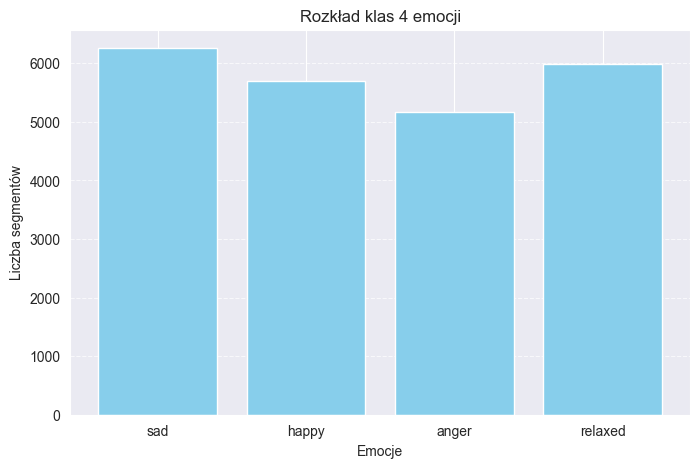

In [12]:
label_counts = Counter(y_over)
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue')
plt.title('Rozkład klas 4 emocji')
plt.xlabel('Emocje')
plt.ylabel('Liczba segmentów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Najlepsze do tej pory wyniki dla zwykłego RandomForestClassifier - wyższe accuracy oraz równomierne rozpoznawanie klas - żadna nie przeważa.

Accuracy:  0.6310784525610547
              precision    recall  f1-score   support

       anger       0.76      0.38      0.51      1035
       happy       0.58      0.80      0.68      1141
     relaxed       0.66      0.54      0.59      1199
         sad       0.62      0.78      0.69      1252

    accuracy                           0.63      4627
   macro avg       0.66      0.62      0.62      4627
weighted avg       0.65      0.63      0.62      4627



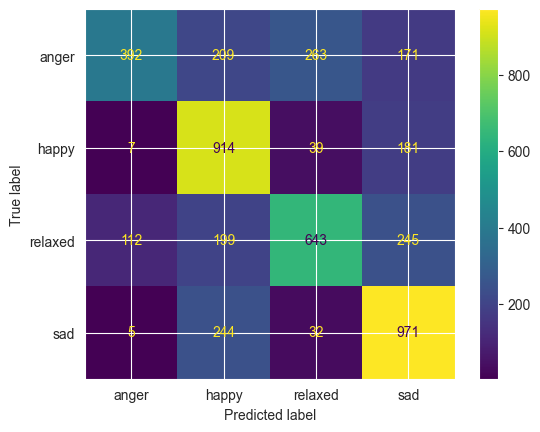

In [16]:
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over_1,
    y_over_en,
    test_size=0.2,
    random_state=42,
    stratify=y_over_en)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_over, y_train_over)

y_pred = clf.predict(X_test_over)
print("Accuracy: ", accuracy_score(y_test_over, y_pred))
print(classification_report(y_test_over, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_over, y_pred, display_labels=le.classes_)

Sieć CNN

In [11]:
# X_over_cnn = np.expand_dims(X_over_cnn, axis=-1)
if len(X_over_cnn.shape) == 3:
    X_over_cnn = np.expand_dims(X_over_cnn, axis=-1)
y_over_cnn = to_categorical(y_over_en)

X_train, X_test, y_train, y_test = train_test_split(X_over_cnn, y_over_cnn, test_size=0.2, random_state=42, stratify=y_over_en)

In [14]:
print(X_over_cnn.shape)
print(y_over_cnn.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23133, 128, 431, 1)
(23133, 4)
(18506, 128, 431, 1)
(4627, 128, 431, 1)
(18506, 4)
(4627, 4)


In [15]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model_over = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_over.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_over.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 429, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 214, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 212, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 106, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 203520)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    26,050,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,070,404 (99.45 MB)

 Trainable params: 26,070,212 (99.45 MB)

 Non-trainable params: 192 (768.00 B)

In [16]:
history_over = model_over.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10),
               ModelCheckpoint("spec_class_cnn_model.keras",
                save_best_only=True)]
)

Epoch 1/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 336s 712ms/step - accuracy: 0.2980 - loss: 6.1597 - val_accuracy: 0.3015 - val_loss: 1.3815
Epoch 2/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 316s 682ms/step - accuracy: 0.2745 - loss: 1.6477 - val_accuracy: 0.4106 - val_loss: 2.5311
Epoch 3/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 326s 704ms/step - accuracy: 0.2783 - loss: 1.7264 - val_accuracy: 0.2890 - val_loss: 1.3899
Epoch 4/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 273s 589ms/step - accuracy: 0.2731 - loss: 1.4077 - val_accuracy: 0.2890 - val_loss: 1.4090
Epoch 5/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 311s 672ms/step - accuracy: 0.2682 - loss: 1.3914 - val_accuracy: 0.2863 - val_loss: 1.3943
Epoch 6/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 296s 640ms/step - accuracy: 0.2714 - loss: 1.3866 - val_accuracy: 0.2863 - val_loss: 1.3800
Epoch 7/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.2655 - loss: 1.3827

KeyboardInterrupt: 

Przerwaliśmy uczenie, ponieważ znowu - wyniki były bardzo niskie i się nie poprawiały, a trwało bardzo długo. Teraz badanie sieci CNN z dopasowanymi automatycznie wagami klas.

In [12]:
X_over_cnn = X_over_cnn.astype(np.float32)
mean = np.mean(X_over_cnn)
std = np.std(X_over_cnn)
X_over_cnn_mean = (X_over_cnn - mean) / std

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_over_en), y=y_over_en)
class_weight_dict = dict(enumerate(class_weights))

X_train, X_test, y_train, y_test = train_test_split(X_over_cnn_mean, y_over_cnn, test_size=0.2, random_state=42, stratify=y_over_en)

In [13]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model_over = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_over.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_over.summary()

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 429, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 214, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 212, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 106, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 104, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93184)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    23,855,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,949,956 (91.36 MB)

 Trainable params: 23,949,508 (91.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
history_over = model_over.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    # class_weight=class_weight_dict,
    callbacks=[EarlyStopping(patience=5),
               ModelCheckpoint("spec_class_cnn_model.keras",
                save_best_only=True)]
)

Epoch 1/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 375s 780ms/step - accuracy: 0.3392 - loss: 4.6284 - val_accuracy: 0.3522 - val_loss: 2.9289
Epoch 2/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 330s 713ms/step - accuracy: 0.3342 - loss: 1.3073 - val_accuracy: 0.3687 - val_loss: 1.2512
Epoch 3/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 344s 743ms/step - accuracy: 0.3216 - loss: 1.3123 - val_accuracy: 0.3847 - val_loss: 1.2302
Epoch 4/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 313s 676ms/step - accuracy: 0.3240 - loss: 1.3559 - val_accuracy: 0.3458 - val_loss: 1.4333
Epoch 5/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 316s 682ms/step - accuracy: 0.3317 - loss: 1.3516 - val_accuracy: 0.3911 - val_loss: 1.2580
Epoch 6/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 319s 688ms/step - accuracy: 0.3422 - loss: 1.2920 - val_accuracy: 0.3836 - val_loss: 1.2151
Epoch 7/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 324s 699ms/step - accuracy: 0.3407 - loss: 1.2812 - val_accuracy: 0.3663 - val_loss: 13.2403
Epoch 8/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 319s 689ms/step - accuracy: 0.3117 

Wyniki są o wiele niższe i niezadowalające - tym razem happy nie jest w ogólne wykrywane.

145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step
Accuracy:  0.36287011022260646
              precision    recall  f1-score   support

       anger       0.49      0.38      0.43      1035
       happy       0.00      0.00      0.00      1141
     relaxed       0.41      0.09      0.15      1199
         sad       0.33      0.94      0.49      1252

    accuracy                           0.36      4627
   macro avg       0.31      0.35      0.27      4627
weighted avg       0.31      0.36      0.27      4627



C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

[Text(0, 0.5, 'anger'),
 Text(0, 1.5, 'happy'),
 Text(0, 2.5, 'relaxed'),
 Text(0, 3.5, 'sad')]

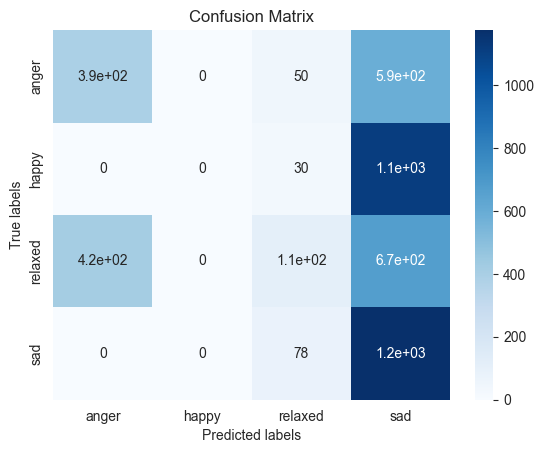

In [15]:
y_pred = model_over.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

confusion_matrix = confusion_matrix(y_true_labels, y_pred_labels)
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

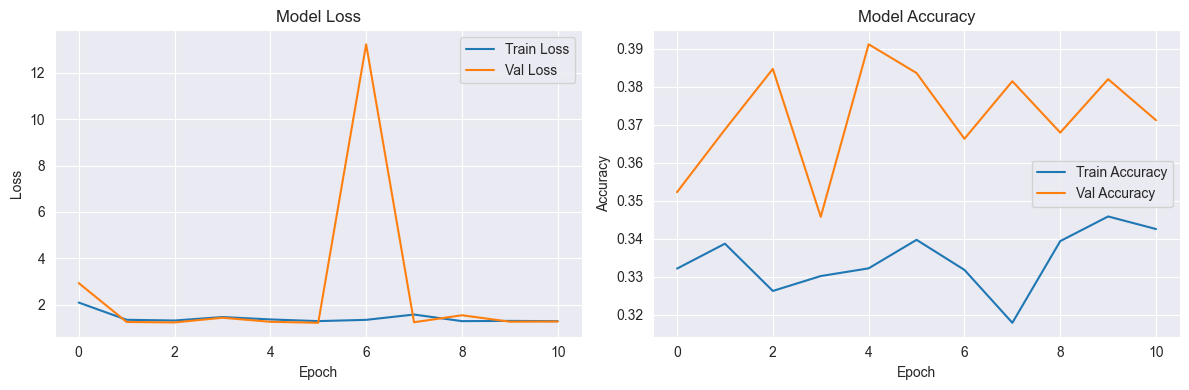

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_over.history['loss'], label='Train Loss')
plt.plot(history_over.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_over.history['accuracy'], label='Train Accuracy')
plt.plot(history_over.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

MLP

In [18]:
model_mlp = Sequential([
    Flatten(input_shape=input_shape),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_mlp.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_mlp = model_mlp.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(patience=5),
               ModelCheckpoint("spec_class_cnn_model.keras",
                save_best_only=True)]
)

C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 57s 120ms/step - accuracy: 0.2936 - loss: 11.7878 - val_accuracy: 0.2666 - val_loss: 1.4079
Epoch 2/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 48s 104ms/step - accuracy: 0.2652 - loss: 1.7845 - val_accuracy: 0.2412 - val_loss: 1.4641
Epoch 3/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - accuracy: 0.2535 - loss: 1.5934 - val_accuracy: 0.2890 - val_loss: 1.4715
Epoch 4/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - accuracy: 0.2533 - loss: 1.5283 - val_accuracy: 0.2399 - val_loss: 1.4267
Epoch 5/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - accuracy: 0.2585 - loss: 1.9194 - val_accuracy: 0.2504 - val_loss: 1.5096
Epoch 6/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 48s 102ms/step - accuracy: 0.2565 - loss: 1.6437 - val_accuracy: 0.2501 - val_loss: 1.5226


Wyniki MLP są niższe niż dla RandomForestClassifier

In [19]:
y_pred = model_mlp.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy: ", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

confusion_matrix = confusion_matrix(y_true_labels, y_pred_labels)
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Accuracy:  0.2582666954830344
              precision    recall  f1-score   support

       anger       0.46      0.01      0.01      1035
       happy       0.25      0.98      0.40      1141
     relaxed       0.35      0.02      0.04      1199
         sad       0.62      0.03      0.06      1252

    accuracy                           0.26      4627
   macro avg       0.42      0.26      0.13      4627
weighted avg       0.42      0.26      0.13      4627



TypeError: 'numpy.ndarray' object is not callable

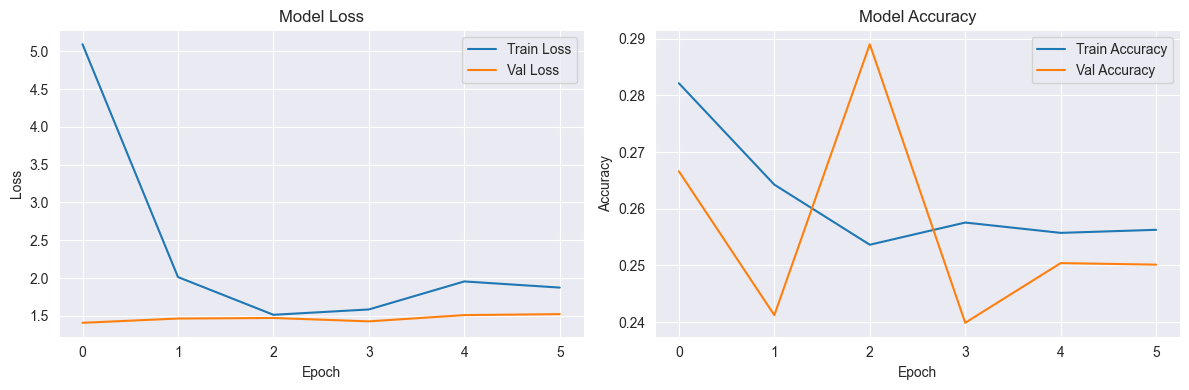

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Inne

In [18]:
from sklearn.svm import SVC

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over_1.astype(np.float32),
    y_over_en,
    test_size=0.2,
    random_state=42,
    stratify=y_over_en)

svc = SVC(kernel='rbf', class_weight='balanced')
svc.fit(X_train_over, y_train_over)

In [ ]:
y_pred = svc.predict(X_test_over)
print("Accuracy: ", accuracy_score(y_test_over, y_pred))
print(classification_report(y_test_over, y_pred, target_names=le.classes_))

In [15]:
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over_1.astype(np.float32),
    y_over_en,
    test_size=0.2,
    random_state=42,
    stratify=y_over_en)

X_small, _, y_small, _ = train_test_split(
    X_train_over, y_train_over,
    test_size=0.7, random_state=42, stratify=y_train_over
)

# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'class_weight': ['balanced']
# }
#
# grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
# grid.fit(X_train_over, y_train_over)
#
# print("Best params:", grid.best_params_)
# print("Accuracy: ", grid.score(X_test_over, y_test_over))

In [16]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_small, y_small)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019382CD22E0>},
                   random_state=42, scoring='accuracy')

In [17]:
print("Best params:", random_search.best_params_)
print("Accuracy:", random_search.score(X_test_over, y_test_over))

Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 98}
Accuracy: 0.5874216555003242


Najlepszy znaleziony do tej pory model z dostrojonymi hiperparametrami

Accuracy:  0.6302139615301491
              precision    recall  f1-score   support

       anger       0.78      0.36      0.49      1035
       happy       0.59      0.80      0.68      1141
     relaxed       0.66      0.53      0.59      1199
         sad       0.61      0.79      0.69      1252

    accuracy                           0.63      4627
   macro avg       0.66      0.62      0.61      4627
weighted avg       0.66      0.63      0.62      4627



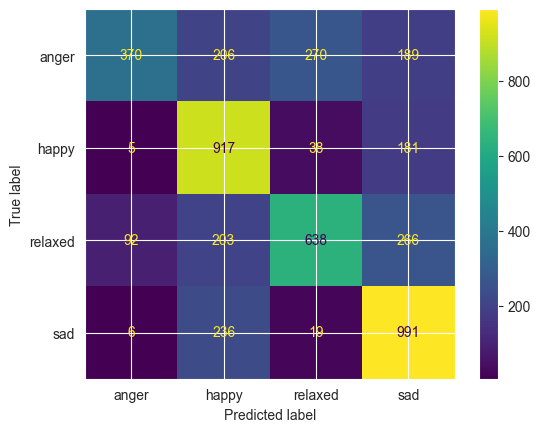

In [18]:
clf = RandomForestClassifier(n_estimators=98, max_depth=None, min_samples_leaf=2, min_samples_split=2, random_state=42)
clf.fit(X_train_over, y_train_over)

y_pred = clf.predict(X_test_over)
print("Accuracy: ", accuracy_score(y_test_over, y_pred))
print(classification_report(y_test_over, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_over, y_pred, display_labels=le.classes_)

In [19]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 1, 2],
    'min_samples_leaf': [2, 5],
    'min_samples_split': [2, 3],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_small, y_small)

print("Best params:", random_search.best_params_)
print("Accuracy:", random_search.score(X_test_over, y_test_over))

Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 98}
Accuracy: 0.5852604279230603


Accuracy:  0.6224335422519991
              precision    recall  f1-score   support

       anger       0.72      0.37      0.49      1035
       happy       0.58      0.80      0.67      1141
     relaxed       0.66      0.50      0.57      1199
         sad       0.61      0.79      0.69      1252

    accuracy                           0.62      4627
   macro avg       0.64      0.61      0.60      4627
weighted avg       0.64      0.62      0.61      4627



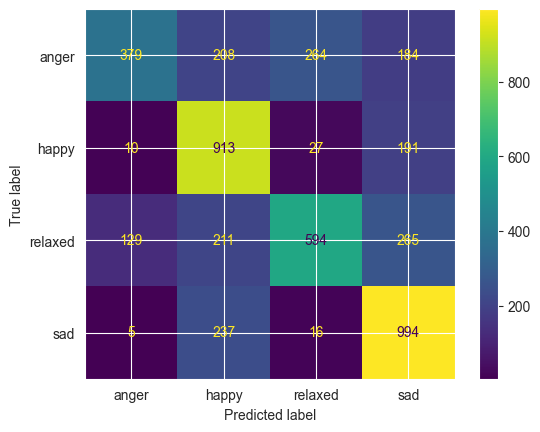

In [21]:
clf = RandomForestClassifier(n_estimators=98, max_depth=None, min_samples_leaf=5, min_samples_split=2, class_weight='balanced', random_state=42)
clf.fit(X_train_over, y_train_over)

y_pred = clf.predict(X_test_over)
print("Accuracy: ", accuracy_score(y_test_over, y_pred))
print(classification_report(y_test_over, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_over, y_pred, display_labels=le.classes_)

Accuracy:  0.6317268208342338
              precision    recall  f1-score   support

       anger       0.78      0.36      0.49      1035
       happy       0.59      0.81      0.68      1141
     relaxed       0.67      0.53      0.59      1199
         sad       0.61      0.80      0.69      1252

    accuracy                           0.63      4627
   macro avg       0.66      0.62      0.61      4627
weighted avg       0.66      0.63      0.62      4627



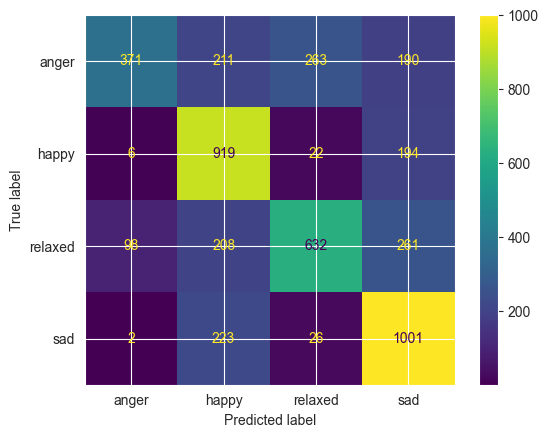

In [22]:
clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=2, min_samples_split=2, class_weight='balanced', random_state=42)
clf.fit(X_train_over, y_train_over)

y_pred = clf.predict(X_test_over)
print("Accuracy: ", accuracy_score(y_test_over, y_pred))
print(classification_report(y_test_over, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_over, y_pred, display_labels=le.classes_)

RandomForestClassifier przyjmuje dane spłaszczone - nie do końca przetwarza melspectrogram jako obraz, tylko jako liczby. Możliwe że przez to, że ma prostszą strukturę, lepiej rozpoznaje emocje. Natomiast sieci CNN przyjmują melspectrogramy w pełnych wymiarach i możliwe, że nie radzą sobie z tak złożonymi strukturami.